# Subtract 1 Raster from Another and Export a New GeoTIFF

Often you need to process 2 raster datasets together to create a new raster output adn then save that output as a new file.

In [1]:
import os
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap
import matplotlib.colors as colors
import seaborn as sns
import numpy as np
import rasterio as rio
from rasterio.plot import plotting_extent
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep

# prettier plotting with seaborn
sns.set(font_scale=1.5, style="whitegrid")

# Get data and set work dir
et.data.get_data("colorado-flood")
os.chdir(os.path.join(et.io.HOME, "earth-analytics"))

Open and plot the lidar DEM. Note that when you read the data, you can use the argument masked = True to ensure that the no data values do not plot and are assigned nan or nodata.

In [2]:
# Define relative path to file
lidar_dem_path = os.path.join("data", "colorado-flood", "spatial",
                             "boulder-leehill-rd", "pre-flood", "lidar",
                             "pre_DTM.tif")

# Open raster data
with rio.open(lidar_dem_path) as lidar_dem:
    lidar_dem_im = lidar_dem.read(1, masked=True)
    
    # Get bounds for plotting
    bounds = plotting_extent(lidar_dem)

### Import DSM

The DSM represents the top of the earth's surface. Thus, it includes trees, buildings and other objects that sit on the Earth.

In [3]:
# Define relative path to file
lidar_dsm_path = os.path.join("data", "colorado-flood", "spatial",
                             "boulder-leehill-rd", "pre-flood", "lidar",
                             "pre_DSM.tif")

with rio.open(lidar_dsm_path) as lidar_dsm:
    lidar_dsm_im = lidar_dsm.read(1, masked=True)
    
lidar_dsm_im

masked_array(
  data=[[--, --, --, ..., 1695.6300048828125, 1695.5899658203125,
         1696.3900146484375],
        [--, --, --, ..., 1695.5999755859375, 1695.6300048828125, 1697.0],
        [--, --, --, ..., 1695.3800048828125, 1695.43994140625,
         1695.449951171875],
        ...,
        [--, --, --, ..., 1681.449951171875, 1681.3900146484375, 1681.25],
        [--, --, --, ..., 1681.719970703125, 1681.5699462890625,
         1681.5599365234375],
        [--, --, --, ..., 1681.8900146484375, 1681.8099365234375,
         1681.739990234375]],
  mask=[[ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        ...,
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False]],
  fill_value=-3.402823e+38,
  dtype=float32)

## Canopy Height Model

The canopy height model (CHM) represents the HEIGHT of the trees. THis is not an elevation value, rather it's the height or distance between the ground and the top of the trees (or buildings or whether object that the lidar system detected and recorded).

Some canopy height models also include buildings, so you need to look closely at your data to ake sure it was properly cleaned before assuming it represents all trees!

### Calculate difference between 2 rasters

There are different ways to calculate a CHM. One easy way is to subtract the DEM from the DSM.

### DSM - DEM = CHM

This math gives you the residual value or difference between the top of the Earth surface and the ground which shoud be the heights of the trees (and buildings if the data haven't been "cleaned").

* Data Tip: Note that this method of subtracting 2 rasters to create a CHM maz not give you the most accurate results! There are better ways to create CHM's using the point clouds themselves.

Before you subtract the 2 rasters, be sure to check to see if they cover the same area.

In [4]:
# Are the bounds the same?
print("Is the spatial extent the same?",
     lidar_dem.bounds == lidar_dsm.bounds)

# Is the resolution the same?
print("Is the resolution the same?",
     lidar_dsm.res == lidar_dem.res)

Is the spatial extent the same? True
Is the resolution the same? True


It's now safe for you to subtract the 2 rasters without significant errors or uncertainty introduced.

In [5]:
# Calculate canopy height model
lidar_chm_im = lidar_dsm_im-lidar_dem_im

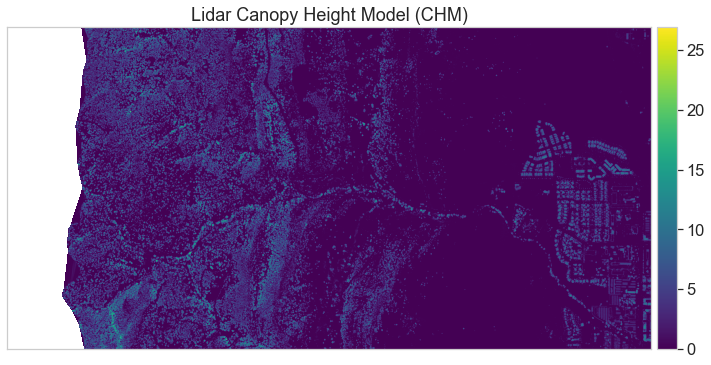

In [6]:
# Plot the CHM
ep.plot_bands(lidar_chm_im,
             cmap="viridis",
             title="Lidar Canopy Height Model (CHM)",
             scale=False)

plt.show()

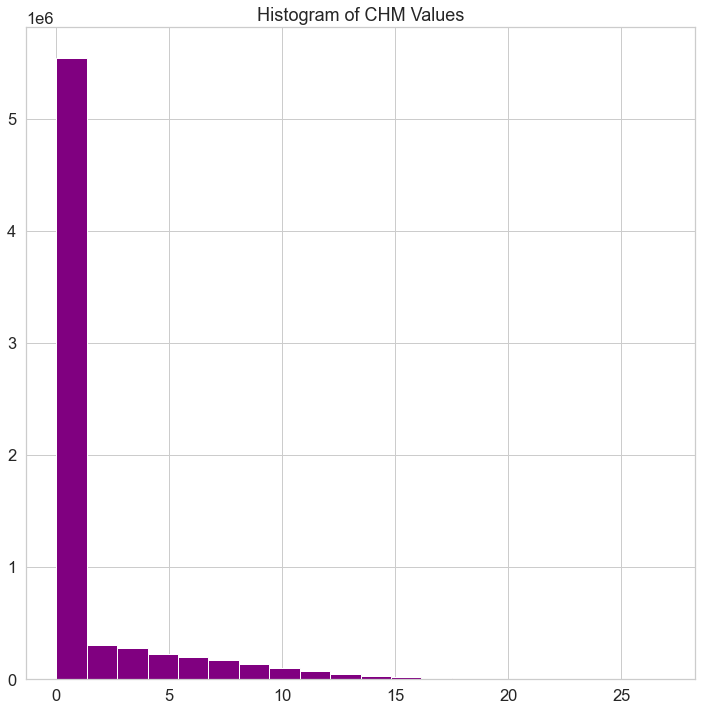

In [7]:
ep.hist(lidar_chm_im,
       colors="purple",
       title="Histogram of CHM Values")

plt.show()

### Explore the CHM Data

Think about the values representing things like trees and buildings in your data.

Do the data make sense?

In [8]:
print("CHM minimum value: ", lidar_chm_im.min())
print("CHM max value: ", lidar_chm_im.max())

CHM minimum value:  0.0
CHM max value:  26.930054


## Export a raster

You can export a raster file in python using the rasterio write() function. Export the CHM that you just created to your data folder. YOu will create a new dir called "outputs" within the colorado-flood directory. This structure allows you to keep things organised, separating your output from the data you downloaded.

In [9]:
os.getcwd()

'C:\\Users\\s1526\\earth-analytics'

In [10]:
os.listdir(os.getcwd())

['data']

In [11]:
if os.path.exists("data/colorado-flood/spatial/outputs"):
    print("The directory exists!")
else:
    os.makedirs("data/colorado-flood/spatial/outputs")

The directory exists!


In [17]:
os.chdir("C:/Users/s1526/Dropbox/Python_Tutorials/Earth Data Analytics/Python/Intermediate/3. Raster")

if os.path.exists("outputs"):
    print("outputs file exist")
else:
    os.makedirs("outputs")

### Exporting Numpy arrays to GeoTIFFs

Next, you need to consider the metadata associated with your chm. Remember that the chm was generated using 2 numpy arrays. Neither of these arrays has spatial data directly associated with it. BUT you do have the rasterio object that has metadata that you can use if you want to assign all of the spatial attributes that are needed to save a usable GeoTIFF file.

**dictionary-metadata-object-here

to apply all of the spatial attributes from 1 of your raster objects, when you write out your new chm raster.

To begin, have a look at the lidar_dem metadata dictionary. Looking at the example below, all of the metadata in that dictionary are the same as what we expect the output chm to have. Thus we can use the metadata as they are.

In [18]:
lidar_dem.meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': -3.4028234663852886e+38,
 'width': 4000,
 'height': 2000,
 'count': 1,
 'crs': CRS.from_epsg(32613),
 'transform': Affine(1.0, 0.0, 472000.0,
        0.0, -1.0, 4436000.0)}

Next, update the nodata value. The number being used currently is difficult to remember. A more standard value like -999.99 could be a better option. To implement this we will do 2 things.

1. You will assign all masked pixels values which represent nodata values to -999.99 using the np.ma.filled() function.
2. Then you will create a new metadata dictionary that contained the updated nodata value.

In [19]:
lidar_chm_im.min()
lidar_chm_im

masked_array(
  data=[[--, --, --, ..., 0.0, 0.1700439453125, 0.9600830078125],
        [--, --, --, ..., 0.0, 0.090087890625, 1.6400146484375],
        [--, --, --, ..., 0.0, 0.0, 0.0799560546875],
        ...,
        [--, --, --, ..., 0.0, 0.0, 0.0],
        [--, --, --, ..., 0.0, 0.0, 0.0],
        [--, --, --, ..., 0.0, 0.0, 0.0]],
  mask=[[ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        ...,
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False]],
  fill_value=-3.402823e+38,
  dtype=float32)

In [21]:
# Fill the masked pixels with a set of no data value
nodatavalue = -999.99
lidar_chm_im_fi = np.ma.filled(lidar_chm_im, fill_value=nodatavalue)
lidar_chm_im_fi.min(), nodatavalue

(-999.99, -999.99)

In [22]:
# Update the metadata to ensure the nodata value is properly documented

# Create dir copy
chm_meta = lidar_dem.meta.copy()

# Update the nodata value to be an easier to use number
chm_meta.update({"nodata": nodatavalue})
chm_meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': -999.99,
 'width': 4000,
 'height': 2000,
 'count': 1,
 'crs': CRS.from_epsg(32613),
 'transform': Affine(1.0, 0.0, 472000.0,
        0.0, -1.0, 4436000.0)}

If you want, you can check things like the shape of the numpy array to ensure that it is the same as the width and height of the DEM. It should be!

In [23]:
# Note the width and height of the DEM above.
# Is the numpy array shape the same?
lidar_chm_im_fi.shape

(2000, 4000)

Finally, you can export your raster layer.
1. You use the same rio.open() syntax that you are used to using except now you specify that you are writing a new file with the "w" argument.
2. You specify the new file name and destination in the rio.open() function e.g: "data/colorado-flood/spatial/outputs/lidar_chm.tiff"
3. You specify the metadata as an "unpacked" dictionary using **lidar_dem.meta - doing this allows you to NOT have to specify EACH and EVERY metadata element individually in your output statement - which would be tedious!
4. Finally you write the file. output_file.write(your-object-name, layer) Notice that when you make this call you specify both the object name and the layer you wish to write to a new file. Also notice the outf is the name of the rasterio object as defined below.

In [26]:
out_path = os.path.join("outputs", "lidar_chm.tif")

with rio.open(out_path, "w", **chm_meta) as outf:
    outf.write(lidar_chm_im_fi, 1)